# HW08 - Instrumental Variables (due November 23rd)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [3]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

<AxesSubplot: xlabel='educ', ylabel='lwage'>

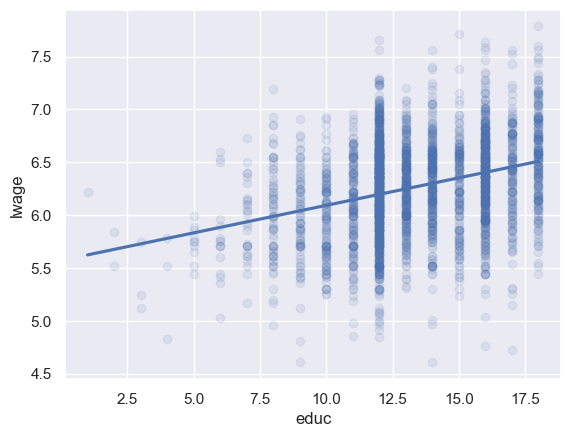

In [5]:
##plot log wages against education
sns.set_theme()

sns.regplot(x='educ', y='lwage', data=df, ci=None, scatter_kws={'alpha':0.1})

In [18]:
##Regress log wages (lwage) against education and include controls, use robust standard errors.

covariates = ['fatheduc', 'motheduc', 'black', 'married']
df = df.dropna(subset=['lwage', 'educ']+covariates)

ols = smf.ols('lwage ~ educ + ' + ' + '.join(covariates), data=df).fit(cov_type='HC1')

**What are other possible confunders?**

The only variable we have that relates to social class is the parents' education level, which does not necessarily translate directly to class. Therefore some representations of class could be confounders.

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

<AxesSubplot: xlabel='nearc4', ylabel='lwage'>

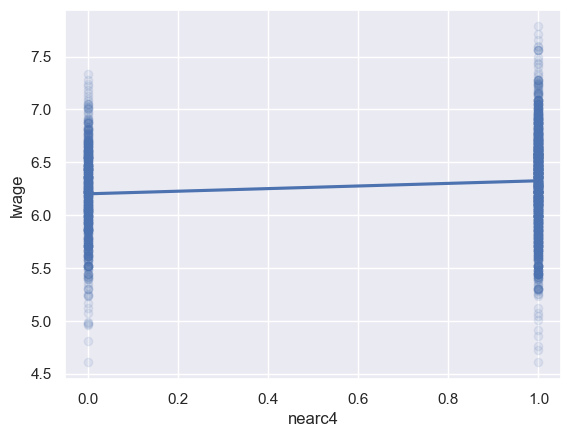

In [19]:
##plot log wages against nearc4
sns.regplot(x='nearc4', y='lwage', data=df, ci=None, scatter_kws={'alpha':0.1})

<AxesSubplot: xlabel='nearc4', ylabel='educ'>

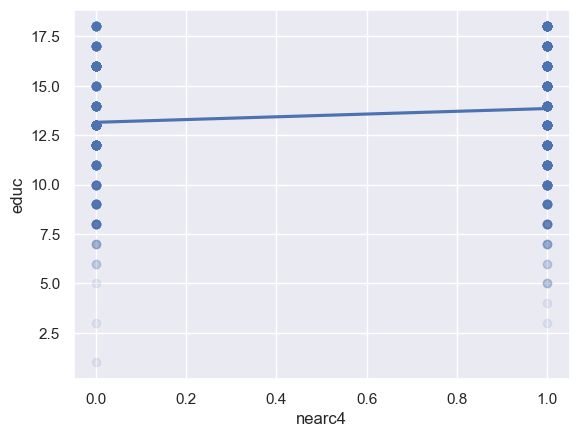

In [20]:
##plot education against nearc4
sns.regplot(x='nearc4', y='educ', data=df, ci=None, scatter_kws={'alpha':0.1})

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**

Positive, because this is a general measure of education. I would think that getting even an bachelor's degree would increase your lifetime salaries, even though graduate degrees don't.

In [27]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
fs = smf.ols('educ ~ nearc4 + ' + ' + '.join(covariates), data=df).fit(cov_type='HC1')
summary_col([fs], stars=True)

,educ
Intercept,9.0672***
,(0.2257)
nearc4,0.3535***
,(0.1035)
fatheduc,0.2084***
,(0.0177)
motheduc,0.1965***
,(0.0215)
black,-0.2345
,(0.1475)


In [28]:
##predict education from the previous regression
df['educhat'] = fs.predict(df)

In [29]:
##run a regression of log wages on education and controls using robust standard errors
twosls = smf.ols('lwage ~ educhat + ' + ' + '.join(covariates), data=df).fit(cov_type='HC1')

In [30]:
##compare the 2sls and ols estimates 
print(summary_col([ols, twosls], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'educhat']))


               lwage I lwage II
-------------------------------
educ           0.041           
               (0.004)         
educhat                0.291   
                       (0.052) 
Intercept      5.766   3.445   
               (0.050) (0.484) 
black          -0.189  -0.128  
               (0.025) (0.029) 
fatheduc       0.000   -0.053  
               (0.003) (0.012) 
married        -0.047  -0.066  
               (0.004) (0.006) 
motheduc       0.009   -0.040  
               (0.004) (0.011) 
R-squared      0.160   0.130   
R-squared Adj. 0.158   0.128   
N              2215    2215    
Standard errors in parentheses.


**What do you think the difference in the estimates is due to?**

Because the people who go more to school because they live close to it are likely the ones who are already disadvantaged to go to school, as they don't have enough resources to travel.

### IV analysis

In [31]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 

exog = sm.add_constant(df[covariates])
iv2sls = IV2SLS(df['lwage'], exog, df['educ'], df['nearc4']).fit(cov_type='unadjusted')
print(iv2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                     -1.4576
Estimator:                    IV-2SLS   Adj. R-squared:                -1.4631
No. Observations:                2215   F-statistic:                    116.79
Date:                Fri, Nov 18 2022   P-value (F-stat)                0.0000
Time:                        19:07:49   Distribution:                  chi2(5)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3.4449     0.8390     4.1061     0.0000      1.8005      5.0892
fatheduc      -0.0533     0.0201    -2.6545     0.00

Same results!